<h1>TransferLearning</h1>

전이학습?
기존에 존재하는 모델로 부터 새로운 모델을 학습시키는것
- 학습 속도 빠름, 정확도 높음
- 이미 잘 훈련된 모델이 있으면 유사한 모델 학습이 쉬움

fine-tuning 세가지 전략

1. 전체 모델을 새로 학습
2. Convolutional base 일부 고정, 나머지계층과 clssifer 새로 학습 
3. Convolutional base 고정, clssifer 새로 학습

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt

import tensorflow as tf

import tensorflow_hub as hub

from tensorflow.keras import layers

import numpy as np

In [2]:
#flowers데이터셋

data_root = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
     untar=True)


In [3]:
#imageNet classifier

classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}


In [4]:

IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])


In [5]:
#ImageDataGenerator: 이미지데이터 학습을 쉽게하기위해 다양한 패키지 제공
#rescale파라메터를 사용해 변환, 텐써 이미지 모듈은 [0,1]사이의 실수 값을 사용


image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)


Found 3670 images belonging to 5 classes.


In [6]:
#image_batch, label_batch

for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break


Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [7]:
#이미지 classifer실행

result_batch = classifier.predict(image_batch)
result_batch.shape


(32, 1001)

In [8]:
#imageNet라벨 불러오기

labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())


In [9]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['cardoon', 'bee', 'cup', 'ice cream', 'daisy', 'bee',
       'head cabbage', 'daisy', 'daisy', 'hip', 'artichoke', 'quill',
       'ant', 'daisy', 'pot', 'daisy', 'rapeseed', 'cardoon', 'daisy',
       'daisy', 'picket fence', 'daisy', 'honeycomb', 'fountain',
       'spider web', 'pot', 'rapeseed', 'clog', 'bee', 'coral fungus',
       'daisy', 'pineapple'], dtype='<U30')

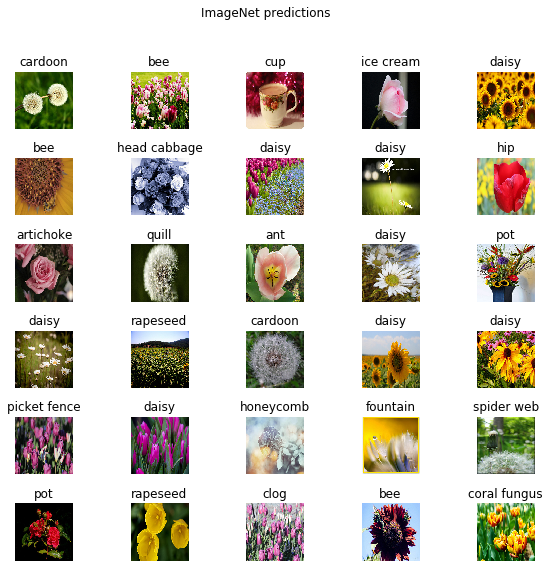

In [10]:
#결과가 이상하게 나옴 이유는? 

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")


In [11]:
#헤드리스 모델 다운로드

feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}


In [12]:
#feature추출

feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))


In [13]:
#1280길이 반환

feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)


(32, 1280)


In [14]:
#feature_extractor_layer의 변수 고정
#모델에서 새로운 layer를 훈련하고 추가

feature_extractor_layer.trainable = False


In [15]:
#Classification head

model = tf.keras.Sequential([
  feature_extractor_layer, #hub layer
  layers.Dense(image_data.num_classes, activation='softmax') #새로운 Classification layer
])

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [16]:
predictions = model(image_batch)

In [17]:
predictions.shape

TensorShape([32, 5])

In [18]:
#모델 학습시키기

model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])


In [19]:

class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()
    

In [20]:

steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])


Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 115.0 steps
Epoch 1/2
115/115 [==============================] - 46s 404ms/step - loss: 0.7145 - acc: 0.9688
Epoch 2/2
115/115 [==============================] - 44s 379ms/step - loss: 0.3414 - acc: 0.9375


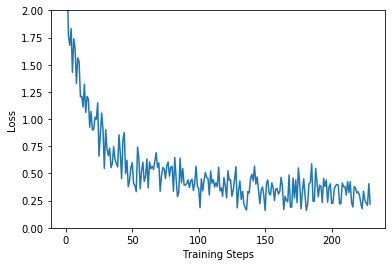

In [21]:

plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)


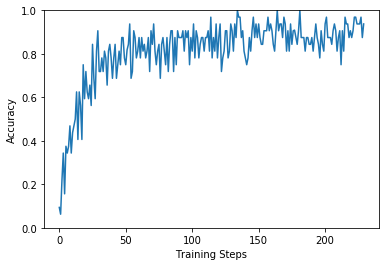

In [22]:
#2번의 epoch만으로도 잘 학습하고 있음

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)


In [23]:
#예측 확인
#클래스 이름의 정렬된 순서 가져옴

class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names


array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [24]:
#모델에 이미지배치를 돌리고 클래스 이름이 위치하도록함

predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]


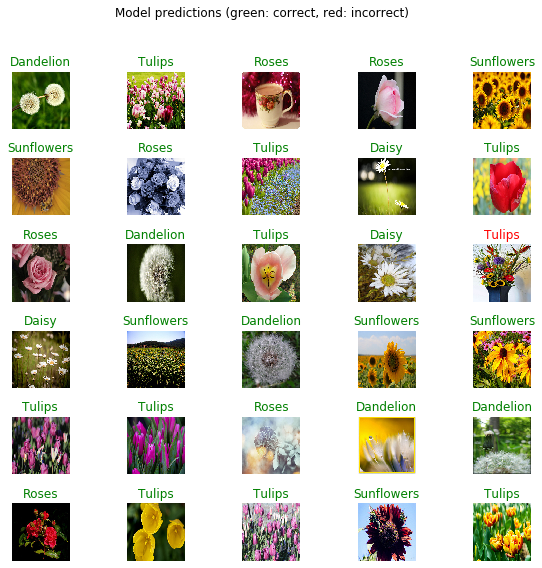

In [25]:
#결과 그리기

label_id = np.argmax(label_batch, axis=-1)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")


In [26]:
#모델 내보내기

import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path, save_format='tf')

export_path


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: /tmp/saved_models/1589532781/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1589532781/assets


'/tmp/saved_models/1589532781'

In [27]:

reloaded = tf.keras.models.load_model(export_path)

result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

abs(reloaded_result_batch - result_batch).max()


0.0